# Random Forest

Random Forest is one type of bagging method from ensemble learning. Here is how sklearn describe bagging and I found it useful and easy to understand:

In [24]:
%matplotlib inline
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

## Bagging

Since single tree are often suffer from high variance, which means when we use split the training data into 2 parts at random, the built model for each half can be quite different. Bagging is a procedure that used to reduce the variance of a statistical leanring method. 

Here is the explaination of the main idea and motivation behind it.
Assume that we have $n$ different sets of observations, each sets of observations can be used as a training dataset. Suppose each training dataset is with variance $\alpha^2$, which is the amount by which our model would change if we estimated it using a different training dataset. The variance of the mean of the sets of the observations is given by $\frac{\alpha^2}{n}$. In other words, averaging a set of observations reduces variance. In practice, it is usually not possible for us to have several training data sets. In Bagging, we generate several training dataset by bootstraping. We take repeated samples from the single training data set.

In the previous section when we estimate the test error using cross validation. We divide the training data set into K folds, and then build our model of the kth fold and evaulate the test error using the left-out kth fold. Then, we get our final estimated test error by averaging the test error from the folds. 

In bagging, it turns out we can use another technique called **Out of Bag Error Estimation** to estimate the test error. Originally, if we also want to use cross validation to estimate the test error of our training data set, performing bagging on large data sets would be computationally expensive. Let's assume we want to use 10-fold cross validation and bootstrap 21 training data set when building a model. In this case, for each fold we'll need to build 20 models, i.e, we train our method on the **bth** bootstrapped training set in order to get our estimated function, denoted by $\hat{f}^b(x)$. We then get our final prediction using the average of the predictions from each model, $\hat{f}^1(x), \hat{f}^2(x), \dots \hat{f}^21(x)$. Therefore, totally we will need to build $21 \times 10 = 210$ models in order to get an estimation of the test error. 

It turns out that we can actually get our test error estimation for a bagged model in an intuitively way. Since we know that in bagging, essentially we fit our model on a subset of the original training data set. For illustration purpose, let's say in each subset, we randomly use 2/3 of the original data set, and we totally take 21 bootstrapped training sets. For the $i_{th}$ observation, it will be in the training set in 14 of the bootstrapped training sets. We can predict the response for the $i_{th}$ observation using each of the trees in which taht observation was out ob bag (OOB). This will yield around 7 predictions for the $i_{th}$ observation. To obtain a single prediction, we can average these predicted responses for regresssion tree or can take a mojority vote for classification tree. By using **Out of Bag Error Estimation**, we will only need to build 21 models but still get a fairly good estimation of the test error. It is particularly convenient when performing bagging on large data sets. 

Below are some description about bagging from Sklearn's documentaion
```
*In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).*

*Bagging methods come in many flavours but mostly differ from each other by the way they draw random subsets of the training set:*
* *When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting.*
* *When samples are drawn with replacement, then the method is known as Bagging.*
* *When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces.*
* *Finally, when base estimators are built on subsets of both samples and features, then the method is known as Random Patches.*
```

## Random Forest 

In bagging, we make predictions using the bootstrapped training set from our original training data set. Suppose we have a very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of the tree that we built using each bootstrapped training set, that most strong predictor would likely be used in every of the bagged trees. If we are averaging many correlated trees, let's say in the worst case, all the trees are the same. Then, the averaged prediction will essentially be the same as a single tree. This means that bagging will not lead to a substaintial reduction in variance over a single tree if most of our bagged tree are correlated with each other. 

In randomforest, each time a split in a tree is considered, $m$ ramdom subset of the $p$ predictors can only be used to make a split. Typically, we choose $m \approx \sqrt{p}$. Randomforest is usually better than bagging since on average $\frac{m-p}{p}$ of the splits will not even consider the most strong predictor that will make the bagged tree become more correlated. According the ISLR book, we can think of this process as decorrelating the trees.   

In this notebook, we are going to use the [Pima Indians Diabetes Dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) and build up a classification model on it.

## Parameters

The main parameters to adjust when using these methods is **n_estimators** and **max_features**. 

* **n_estimators** is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. 

* **max_features** is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. 

Empirical good default values are ```max_features=n_features for regression problems```, and ```max_features=sqrt(n_features)``` for classification tasks (where n_features is the number of features in the data). 

While the most important parameter is the n_estimators and max_features, many other parameters are also available. Here are the some of it, and you can find the description of all the parameters [here].(http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier):

* **n_estimators**: The number of trees in the forest.


* **max_features**: int, float, string or None, optional (default=”auto”)

    The number of features to consider when looking for the best split:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.


* **max_depth**:The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Good results are often achieved when setting ```max_depth=None``` in combination with ```min_samples_split=2```


* **min_samples_split**: int, float, optional (default=2)
    
    The minimum number of samples required to split an internal node:
    * If int, then consider min_samples_split as the minimum number.
    * If float, then min_samples_split is a percentage and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
    
    
* **min_samples_leaf**:  int, float, optional (default=1)
    
    The minimum number of samples required to be at a leaf node:
    * If int, then consider min_samples_leaf as the minimum number.
    * If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.


* **criterion**: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.


* **bootstrap**: Whether bootstrap samples are used when building trees. For random forest, the default is True.


* **oob_score**: Whether to use out-of-bag samples to estimate the generalization accuracy. (?)


* **random_state**:If int, random_state is the seed used by the random number generator.

## Model Building

##### Read Data

In [62]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,-1]

In [63]:
dataframe.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### Make Train and Test Data

In [65]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

In [66]:
X_train.shape

(514, 8)

In [67]:
X_test.shape

(254, 8)

In [68]:
y_train.shape

(514,)

In [69]:
y_test.shape

(254,)

### Bagging Classifer & Random Forest 

##### Fit Model

In the code below, we use cross validation to do model selection in case if we have multiple models that we don't know which one performs the best.

Notice that the ```cross_val_score``` will automatically apply different score metric to different kinds of problems. Since it is binary classification in our case, ```cross_val_score``` apply ```f1 score``` as the score metrics. Therefore, the number *0.756787330317* is the average ```f1 score``` among all the folds that we build.

In [174]:
def fit_bagging(X_train, y_train):
    """Bagged Decision Trees for Classification"""
    seed = 7
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cart = DecisionTreeClassifier()
    num_trees = 100
    model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return(model)

def fit_randomforest(X_train, y_train, max_features="auto"):
    seed=7
    num_trees = 100
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=seed)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return model

In [175]:
model_bag = fit_bagging(X_train, y_train)
model_rf = fit_randomforest(X_train, y_train)

0.774245852187
0.756787330317


##### Make Prediction

In [176]:
# Bagging
y_bag_pred = model_bag.predict(X_test)
pd.Series(y_bag_pred).value_counts()

0.0    165
1.0     89
dtype: int64

In [177]:
# Random Forest
y_rf_pred = model_rf.predict(X_test)
pd.Series(y_rf_pred).value_counts()

0.0    171
1.0     83
dtype: int64

##### Evaluate Result

In [72]:
def evaluate_classification(y_test, y_pred):
    """ A function that calculate all the evaluation metrics for classification problems. """ 
    # single line to calculate ```Precision, Recall, F1 Score```
    # metrics.precision_recall_fscore_support(y_test, y_pred)
    # metrics.precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    
    return {'Confusion Matrix': metrics.confusion_matrix(y_test, y_pred),
           'precision_score': metrics.precision_score(y_test, y_pred),
           'recall_score': metrics.recall_score(y_test, y_pred),
           'f1_score': metrics.f1_score(y_test, y_pred),
           'auc': metrics.auc(fpr, tpr)}


In [178]:
evaluate_classification(y_test, y_bag_pred)

{'Confusion Matrix': array([[134,  34],
        [ 31,  55]]),
 'auc': 0.71857696566998908,
 'f1_score': 0.62857142857142856,
 'precision_score': 0.6179775280898876,
 'recall_score': 0.63953488372093026}

In [179]:
evaluate_classification(y_test, y_rf_pred)

{'Confusion Matrix': array([[140,  28],
        [ 31,  55]]),
 'auc': 0.73643410852713176,
 'f1_score': 0.65088757396449703,
 'precision_score': 0.66265060240963858,
 'recall_score': 0.63953488372093026}

We see that since bagging using all the feature to generate the forest, the AUC from the Bagging is lower than Random forest. It aligns with our knowledge that by using only $m$ ramdom subset of the $p$ predictors, random forest can lower the variance of the model, which leads to a better test error.

### Feature Importance

Although the collection of bagged trees is much more difficult to interpret than a single tree, we can obtain an overall summary of the importance of each predictor using the RSS(for bagging regression trees) or the Gini index(for bagging classification trees). 

In the case of bagging regression trees, we can record the total amount that the RSS is decreased due to splits over a given predictor, averaged over all B trees. Similarly, in the context of bagging classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor, averaged over all B trees.

In the `feature_importances_` from *Sklearn*, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is calculated using Gini importance.

In [184]:
def viz_importance(model, feature_names, n_features):
    """Print out the relative importance of predictors"""
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:        
        importances = np.mean([tree.feature_importances_ 
                                       for tree in model.estimators_], axis=0)
    
    idx = np.argsort(importances)[::-1]
    names = feature_names[idx]
    scores = importances[idx]
    
    if hasattr(model, 'estimators_'):
        tree_importances = np.asarray([tree.feature_importances_
                                       for tree in model.estimators_])
        importances_std = np.std(tree_importances, axis = 0)
        scores_std = importances_std[idx]            
    
    y_pos = np.arange(1, n_features + 1)
    plt.barh(y_pos, scores[::-1], align = 'center', xerr = scores_std[::-1])
    plt.yticks(y_pos, names[::-1])
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')    

    print("Feature ranking:")
    for i in range(X.shape[1]):        
        print("%d. feature %s (%f, var(%f))" % (i + 1, names[i], scores[i], scores_std[i]))
       

Feature ranking:
1. feature plas (0.374610, var(0.046965))
2. feature mass (0.161982, var(0.038209))
3. feature age (0.136701, var(0.040212))
4. feature pedi (0.111333, var(0.038660))
5. feature pres (0.068368, var(0.027248))
6. feature preg (0.051263, var(0.021346))
7. feature skin (0.048540, var(0.024249))
8. feature test (0.047204, var(0.026215))


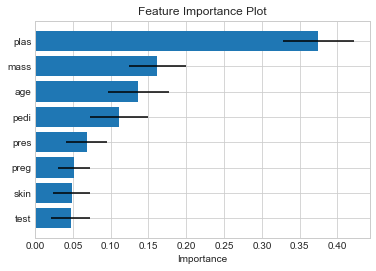

In [185]:
viz_importance(model_bag, dataframe.columns[0:8], X.shape[1])

Feature ranking:
1. feature plas (0.263358, var(0.080191))
2. feature mass (0.164260, var(0.055310))
3. feature age (0.158906, var(0.053437))
4. feature pedi (0.113582, var(0.037402))
5. feature pres (0.086806, var(0.031984))
6. feature skin (0.074008, var(0.032079))
7. feature preg (0.069775, var(0.030180))
8. feature test (0.069305, var(0.032802))


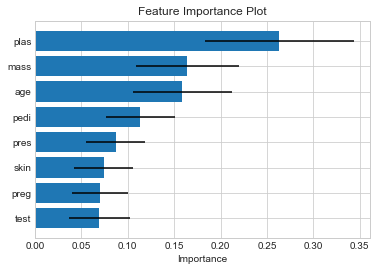

In [180]:
viz_importance(model_rf, dataframe.columns[0:8], X.shape[1])

Comparing the result of bagging and random forest, we can see that `plas` seems to be a strong predictor. Therefore, in bagging, the importance of it is much higher than all the other features. In constrast, in random forest, since each time we can only use a subset of all the features, the importance is more balanced.

From the above plot, we can see that the feature `plas` has the highest importance across all the features, meaning that in all the splits using `plas` as the feature to make a split, the total decreasing amount averaged by the number of nodes that use `plas` as the feature to make a split is the highest. 

Every time when we use `plas` to make a split, there is a decreased amount, the calculated variance is the variance of the decreasing amount among all the nodes that use `plas` to make a split.

Reference:

* https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/
* http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
* http://scikit-learn.org/stable/modules/ensemble.html#
* [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/trees/random_forest.ipynb
* http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/